In [59]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import sklearn.metrics
from statsmodels.stats.multitest import multipletests
import scipy.stats
import scipy
import pyranges as pr
from io import StringIO

In [2]:
plt.rcParams['figure.dpi'] = 1800
plt.ioff()

In [3]:
pp = PdfPages('/lila/data/deyk/fabiha/20231211_mwe/test.pdf')

## gene nomenclature loading

In [3]:
gene_loc="/lila/data/deyk/IGVF/IGVF_Cellular_Programs_Benchmark/PoPS_P2D_benchmark/supplemental_data/NCBI37.3.ensembl.gene.loc"

In [4]:
gene_nomenclature=pd.read_table(gene_loc)

In [5]:
gene_nomenclature = gene_nomenclature[~gene_nomenclature["Ensembl"].duplicated(keep='first')] # not best method but need to keep unique

In [6]:
gene_nomenclature

,NCBI,chr,start,end,strand,HGNC,Ensembl
0,79501,1,69091,70008,+,OR4F5,ENSG00000186092
1,100996442,1,142447,174392,-,LOC100996442,ENSG00000238009
2,729759,1,367659,368597,+,OR4F29,ENSG00000284733
3,81399,1,621096,622034,-,OR4F16,ENSG00000284662
4,148398,1,859993,879961,+,SAMD11,ENSG00000187634
...,...,...,...,...,...,...,...
18311,442867,Y,26764151,26785354,+,BPY2B,ENSG00000183795
18312,57054,Y,26909216,26959639,-,DAZ3,ENSG00000187191
18313,57135,Y,26979967,27053187,+,DAZ4,ENSG00000205916
18314,442868,Y,27177048,27198251,-,BPY2C,ENSG00000185894


# PoPS Code Setup

In [7]:
scripts_dir = "/lila/data/deyk/fabiha/20231211_mwe/clustering_scripts"

## marginal linear regression

In [8]:
py_script = r'''# Type echo "set enable-bracketed-paste off" >> ~/.inputrc before pasting this code in the python console on the cluster. 
# you need 100 to 120GB for this code to run. You can try with smaller RAM but use memory_limit im dt.fread()

#module load gcc/10.2.0
#module load python/3.7.1
#echo "set enable-bracketed-paste off" >> ~/.inputrc
#source activate kge
#python

import pandas as pd
import numpy as np
import argparse
import statsmodels.api as sm
from scipy.stats import pearsonr
import scipy
import datatable as dt

# features="/data/deyk/kushal/IGVF_GWAS_benchmark/PoPS_P2D_benchmark/supplemental_data/PoPS.features.txt.gz"
# gene_loc="/data/deyk/kushal/IGVF_GWAS_benchmark/PoPS_P2D_benchmark/supplemental_data/NCBI37.3.ensembl.gene.loc"
# gene_results="/data/deyk/kushal/IGVF_GWAS_benchmark/PoPS_P2D_benchmark/supplemental_data/Year_ended_full_time_education.sumstats"
# chunk=0
# numchunks=50
# out="/data/deyk/kushal/IGVF_GWAS_benchmark/PoPS_P2D_benchmark/features/MAGMA_0kb/Year_ended_full_time_education.sumstats"

def marginal_ols(X, Y):
    model = sm.OLS(Y, X).fit()
    coef = model.params[0]
    std_er = model.bse[0]
    R2 = model.rsquared
    pval = model.pvalues[0]
    return coef, std_er, pval, R2

def munge_sigma(args):
    f = open(args.gene_results+'.gene_trait'+'.genes.raw')
    lines = list(f)[2:]
    lines = [np.asarray(line.strip('\n').split(' ')) for line in lines]
    sigmas = []
    for chrom in range(1,23):
        chr_start = min(np.where([int(line[1])==chrom for line in lines])[0])
        chr_end = max(np.where([int(line[1])==chrom for line in lines])[0])
        lines_chr = lines[chr_start:chr_end+1]
        n_genes = len(lines_chr)
        sigma_chr = np.zeros([n_genes, n_genes])
        for i in range(n_genes):
            line = lines_chr[i]
            if line.shape[0] > 9:
                gene_corrs = np.asarray([float(c) for c in line[9:]])
                sigma_chr[i, i-gene_corrs.shape[0]:i] = gene_corrs
        sigma_chr = sigma_chr+sigma_chr.T+np.identity(n_genes)
        sigmas.append(sigma_chr)
    return sigmas


def compute_Ls(sigmas, args):
    Ls = []
    min_lambda = 0
    for sigma in sigmas:
        W = np.linalg.eigvalsh(sigma)
        min_lambda = min(min_lambda, min(W))
    Y = pd.read_table(args.gene_results+'.gene_trait'+'.genes.out', delim_whitespace=True).ZSTAT.values
    ridge = abs(min(min_lambda, 0))+.05+.9*max(0, np.var(Y)-1)
    for sigma in sigmas:
        sigma = sigma+ridge*np.identity(sigma.shape[0])
        L = np.linalg.cholesky(np.linalg.inv(sigma))
        Ls.append(L)
    full_L = scipy.linalg.block_diag(Ls[0], Ls[1], Ls[2], Ls[3], Ls[4], Ls[5], Ls[6], Ls[7], Ls[8], Ls[9], Ls[10], Ls[11], Ls[12], Ls[13], Ls[14], Ls[15], Ls[16], Ls[17], Ls[18], Ls[19], Ls[20], Ls[21])
    return full_L

def main(args):
    f_df_chunk = dt.fread(args.features, memory_limit=75)
    f_df = f_df_chunk.to_pandas()
    gene_nomenclature=pd.read_table(args.gene_loc)
    intersect_ensembl = np.intersect1d(np.array(f_df.ENSGID), np.array(gene_nomenclature.Ensembl))
    oo = [ np.where(f_df.ENSGID == x)[0][0] for x in intersect_ensembl.astype('str') ]
    f_df2 = f_df.iloc[oo,:].reset_index(drop=True)
    oo2 = [ np.where(gene_nomenclature.Ensembl == x)[0][0] for x in intersect_ensembl.astype('str') ]
    gene_nomenclature2 = gene_nomenclature.iloc[oo2,:].reset_index(drop=True)
    f_df2.insert(0, 'NCBI', np.array(gene_nomenclature2.NCBI).astype('str').tolist())
    f_df2.ENSGID.equals(gene_nomenclature2.Ensembl)
    gene_scores = pd.read_table(args.gene_results+'.gene_trait'+'.genes.out', delim_whitespace=True)[['GENE', 'ZSTAT']]
    intersect_ncbi = np.intersect1d(np.array(f_df2.NCBI).astype(str), np.array(gene_scores.GENE).astype(str))
    oo3 = [ np.where(np.array(f_df2.NCBI).astype(str) == x)[0][0] for x in intersect_ncbi.astype('str') ]
    oo4 = [ np.where(np.array(gene_scores.GENE).astype(str) == x)[0][0] for x in intersect_ncbi.astype('str') ]
    gene_scores2 = gene_scores.iloc[oo4,:].reset_index(drop=True)
    gene_scores2.GENE = gene_scores2.GENE.astype(str)
    f_df3 = f_df2.iloc[oo3,:].reset_index(drop=True)
    f_df3.NCBI = f_df3.NCBI.astype(str)
    f_df3.NCBI.equals(gene_scores2.GENE)
    gene_scores_zstat = gene_scores2.ZSTAT.values - np.mean(gene_scores2.ZSTAT.values)
    f = open(args.gene_results+'.gene_trait'+'.genes.raw')
    lines = list(f)[2:]
    lines = [np.asarray(line.strip('\n').split(' ')) for line in lines]
    magma_genes = np.array([x[0] for x in lines])
    uu = [ np.where(magma_genes == x)[0][0] for x in np.array(f_df3.NCBI) ]
    magma_genes2 = magma_genes[uu]
    sigmas =munge_sigma(args)
    full_L = compute_Ls(sigmas, args)
    full_L2 = full_L[uu,:][:,uu]
    ## full_L2 has the same order as that of f_df3, magma_genes2 and gene_scores2
    LY = np.matmul(full_L2, gene_scores_zstat)
    Num_features=57743
    Xmat = f_df3.iloc[:,2:Num_features]
    #chunk_ids=np.array_split(range(Xmat.shape[1]), args.numchunks)
    #Xmat2 = Xmat.iloc[:,chunk_ids[int(args.chunk)]]
    Xmat2 = Xmat
    nf = Xmat2.shape[1]
    coefs = np.zeros(nf)
    std_ers = np.zeros(nf)
    pvals = np.zeros(nf)
    rsquared = np.zeros(nf)
    ## f_df3 and gene_scores2 has the same genes arranged in same order
    for i in range(nf):
        LX = np.matmul(full_L2, Xmat2.iloc[:,i].astype(float))
        coef, std_er, pval, r2 = marginal_ols(LX, LY)
        coefs[i] = coef
        std_ers[i] = std_er
        pvals[i] = pval
        rsquared[i] = r2
        print(i)
    sig_results = pd.DataFrame(data={'Feature': Xmat2.columns.values[0:], 'BETA': coefs, 'SE': std_ers, 'P': pvals, 'R2': rsquared})[['Feature', 'BETA', 'SE', 'P', 'R2']]
    selected = sig_results.loc[sig_results.P<=.05, ['Feature', 'BETA', 'SE',  'P', 'R2']].values
    #np.savetxt(args.out+'.chunk.'+ str(args.chunk) + '.features',  selected, fmt='%s')
    np.savetxt(args.out+'.features',  selected, fmt='%s')

parser = argparse.ArgumentParser()
parser.add_argument('--features', help='Path to gene features', type=str)
parser.add_argument('--gene_loc', help='Path to gene nomenclature', type=str)
parser.add_argument('--gene_results', help='Prefix to gene analysis output from MAGMA', type=str)
#parser.add_argument('--chunk', help='Chunk label (for parallel processing of features)', type=int)
#parser.add_argument('--numchunks', help='Number of chunks', type=int)
parser.add_argument('--out', help='Prefix to output for selected features', type=str)

if __name__ == '__main__':
    args = parser.parse_args()
    main(args)
'''

filename = f"{scripts_dir}/pops.marginal_program_benchmark.magma.py"
with open(filename, "w") as f:
    f.write(py_script)

In [9]:
magma_cell = "/data/deyk/IGVF/IGVF_Cellular_Programs_Benchmark/PoPS_P2D_benchmark/supplemental_data/MAGMA_GENE_CELL_0"
gene_loc = "/lila/data/deyk/IGVF/IGVF_Cellular_Programs_Benchmark/PoPS_P2D_benchmark/supplemental_data/NCBI37.3.ensembl.gene.loc"
sumstats_taskfile = "/lila/data/deyk/IGVF/IGVF_Cellular_Programs_Benchmark/PoPS_P2D_benchmark/supplemental_data/traits_pops_benchmark.txt"

marginal_sh_script = r'''module load gcc/10.2.0

module load anaconda/anaconda3
source /lila/home/fabihat/anaconda3/etc/profile.d/conda.sh
conda activate benchmarking

magma_cell={$MAGMA_CELL}
output_cell={$OUTPUT_CELL}
features_file={$FEATURES_FILE}
gene_loc={$GENE_LOC}
sumstats_taskfile={$SUMSTATS_TASKFILE}

IFS="
"

for step in `cat $sumstats_taskfile | awk '{print $1}' | sort | uniq`;
do
    sumstats_file=`echo $step | awk '{print $1}'`
    echo $sumstats_file
    traitname=$sumstats_file
    if [ ! -f $output_cell/$traitname.features ]
    then
    cmd="python3 pops.marginal_program_benchmark.magma.py --features $features_file --gene_loc $gene_loc --gene_results $magma_cell/$traitname --out $output_cell/$traitname"
    bsub -W 2440 -R "rusage[mem=30]" -o {$SCRIPT_OUT} -e {$SCRIPT_ERR} -n 1 "$cmd"
    fi
done
'''

def marginal_writer(script_dir, features_file_cell, output_cell, name):
    output_cell = f"{output_cell}"
    features_file = f"{features_file_cell}/{name}.txt.gz"
    script_out = f"{script_dir}/{name}_marginal.out"
    script_err = f"{script_dir}/{name}_marginal.err"
    
    filename = f"{scripts_dir}/pops.marginal_program_benchmark_{name}.magma.sh"
    with open(filename, "w") as f:
        temp = marginal_sh_script.replace("{$MAGMA_CELL}", magma_cell)
        temp = temp.replace("{$OUTPUT_CELL}", output_cell)
        temp = temp.replace("{$FEATURES_FILE}", features_file)
        temp = temp.replace("{$GENE_LOC}", gene_loc)
        temp = temp.replace("{$SUMSTATS_TASKFILE}", sumstats_taskfile)
        temp = temp.replace("{$SCRIPT_OUT}", script_out)
        temp = temp.replace("{$SCRIPT_ERR}", script_err)
        f.write(temp)

## joint linear regression

In [10]:
py_script = r'''# source /n/groups/price/kushal/env/pops/bin/activate
## python 3.7.4, gcc: 6.2.0, use python3 and pip3 always

import pandas as pd
import numpy as np
import scipy as sc
import argparse
from sklearn.linear_model import LinearRegression,RidgeCV
from sklearn.metrics import make_scorer
import copy

# gene_loc='/n/groups/price/kushal/extras/NCBI37.3.ensembl.gene.loc'
# features_file='/data/deyk/kushal/IGVF_GWAS_benchmark/PoPS_P2D_benchmark/supplemental_data/PoPS.features.txt.gz'
# gene_results='/data/deyk/kushal/IGVF_Cellular_Programs_Benchmark/PoPS_P2D_benchmark/supplemental_data/MAGMA_GENE_CELL_0/UKB_460K.pigment_HAIR.sumstats'
# selected_features_file='/data/deyk/kushal/IGVF_Cellular_Programs_Benchmark/PoPS_P2D_benchmark/pooled_features/MAGMA_0kb/UKB_460K.pigment_HAIR.sumstats.features'
# chromosome=22
# out='/data/deyk/kushal/IGVF_Cellular_Programs_Benchmark/PoPS_P2D_benchmark/predicted_scores/MAGMA_0kb/UKB_460K.pigment_HAIR.sumstats'


def munge_sigma(args):
	f = open(args.gene_results+'.gene_trait' + '.genes.raw')
	lines = list(f)[2:]
	lines = [np.asarray(line.strip('\n').split(' ')) for line in lines]
	sigmas = []
	gene_metadata = []
	gene_lists = []
	for chrom in range(1,23):
		chr_start = min(np.where([int(line[1])==chrom for line in lines])[0])
		chr_end = max(np.where([int(line[1])==chrom for line in lines])[0])
		lines_chr = lines[chr_start:chr_end+1]
		n_genes = len(lines_chr)
		sigma_chr = np.zeros([n_genes, n_genes])
		gene_NSNPs = np.zeros(n_genes)
		gene_NPARAM = np.zeros(n_genes)
		gene_MAC = np.zeros(n_genes)
		for i in range(n_genes):
			line = lines_chr[i]
			gene_NSNPs[i] = line[4]
			gene_NPARAM[i] = line[5]
			gene_MAC[i] = line[7]
			if line.shape[0] > 9:
				gene_corrs = np.asarray([float(c) for c in line[9:]])
				sigma_chr[i, i-gene_corrs.shape[0]:i] = gene_corrs
		sigma_chr = sigma_chr+sigma_chr.T+np.identity(n_genes)
		sigmas.append(sigma_chr)
		gene_metadata_chr = pd.DataFrame(data={'NSNPS': gene_NSNPs, 'NPARAM': gene_NPARAM, 'MAC': gene_MAC})
		gene_metadata.append(gene_metadata_chr)
		gene_list_chr = [line[0] for line in lines_chr]
		gene_lists.append(gene_list_chr)
	return sigmas, gene_metadata, gene_lists

def compute_Ls(sigmas, args):
	Ls = []
	min_lambda=0
	for sigma in sigmas:
		W = np.linalg.eigvalsh(sigma)
		min_lambda = min(min_lambda, min(W))
	Y = pd.read_table(args.gene_results+'.gene_trait'+ '.genes.out', delim_whitespace=True).ZSTAT.values
	ridge = abs(min_lambda)+.05+.9*max(0, np.var(Y)-1)
	for sigma in sigmas:
		sigma = sigma+ridge*np.identity(sigma.shape[0])
		L = np.linalg.cholesky(np.linalg.inv(sigma))
		Ls.append(L)
	return Ls

def build_control_covariates(metadata):
	genesize = metadata.NPARAM.values.astype(float)
	genedensity = metadata.NPARAM.values/metadata.NSNPS.values
	inverse_mac = 1.0/metadata.MAC.values
	cov = np.stack((genesize, np.log(genesize), genedensity, np.log(genedensity), inverse_mac, np.log(inverse_mac)), axis=1)
	return cov

def build_training(matrix_list, chrom):
	full_matrix = np.concatenate(matrix_list[0:chrom-1]+matrix_list[chrom:22])
	full_matrix = np.real(full_matrix)
	return full_matrix

def project_out_cov(Y, C):
	lm = LinearRegression(fit_intercept=False)
	lm.fit(C, Y)
	Y_adj = Y - np.matmul(C, lm.coef_)
	return Y_adj

def corr_score(Y, Y_pred):
	score = sc.stats.pearsonr(Y, Y_pred)[0]
	return score

def initialize_regressor():
	scorer = make_scorer(corr_score)
	alphas = np.logspace(-2, 10, num=12)
	regr = RidgeCV(alphas=alphas, scoring=scorer, fit_intercept=False)
	return regr


def main(args):
	feature_df = pd.read_table(args.gene_loc)[['NCBI', 'Ensembl', 'chr']]
	#selected_features = np.loadtxt(args.selected_features_file, dtype=str).tolist()
	selected_features = pd.read_csv(args.selected_features_file, header=None)[0].to_list()
	f_cols = ['ENSGID']+selected_features
	print("feature_file", args.features_file)
	features = pd.read_table(args.features_file, sep=",", usecols=f_cols)
	#[s for s in features.columns if "control" in s]
	intersect_ensembl = np.intersect1d(np.array(features.ENSGID), np.array(feature_df.Ensembl))
	oo = [ np.where(features.ENSGID == x)[0][0] for x in intersect_ensembl.astype('str') ]
	oo2 = [ np.where(feature_df.Ensembl == x)[0][0] for x in intersect_ensembl.astype('str') ]
	features2 = features.iloc[oo, :].reset_index(drop=True)
	gene_nomenclature2 = feature_df.iloc[oo2, :].reset_index(drop=True)
	gene_nomenclature2.NCBI = gene_nomenclature2.NCBI.astype('str')
	features2.insert(0, 'NCBI', np.array(gene_nomenclature2.NCBI).astype('str').tolist())
	features2.ENSGID.equals(gene_nomenclature2.Ensembl)
	sigmas, metadata, gene_lists = munge_sigma(args)
	Ls = compute_Ls(sigmas, args)
	gene_scores = pd.read_table(args.gene_results+'.gene_trait' + '.genes.out', delim_whitespace=True)[['GENE', 'ZSTAT']]
	gene_scores.rename(columns={'GENE': 'NCBI'}, inplace=True)
	gene_scores.NCBI = gene_scores.NCBI.astype('str')
	features2.NCBI=features2.NCBI.astype('str')
	gene_features=gene_nomenclature2.merge(features2, on='NCBI', how='inner')
	LXs = []
	LCs = []
	LYs = []
	for chrom in range(22):
		L = Ls[chrom]
		genes_of_interest = np.intersect1d(gene_lists[chrom], features2.NCBI)
		genes = pd.DataFrame(data={'NCBI': genes_of_interest})
		genes.NCBI=genes.NCBI.astype('str')
		FF2 = genes.merge(gene_features, on='NCBI', how='inner')
		FF2 = gene_scores.merge(FF2, on="NCBI", how="inner")
		Y = FF2.ZSTAT.values
		oo = [np.where(np.array(gene_lists[chrom]) == x)[0][0] for x in FF2.NCBI.astype('str').tolist()]
		C = build_control_covariates(metadata[chrom].iloc[oo,:])
		L2=L[oo,:][:,oo]
		X = FF2.values[:,5:].astype(float)
		LX = np.matmul(L2, X)
		LC = np.matmul(L2, C)
		LY = np.matmul(L2, Y)
		LXs.append(LX)
		LCs.append(LC)
		LYs.append(LY)
		print("chr:", chrom)
	#chromosome=1
	X_train = build_training(LXs, args.chromosome)
	C_control = build_training(LCs, args.chromosome)
	Y_train = build_training(LYs, args.chromosome)
	Y_train = project_out_cov(Y_train, C_control) ## remove effect of the covariates 
	Y_train = Y_train-np.mean(Y_train)
	regr = initialize_regressor()
	regr.fit(X_train, Y_train)
	betahat = regr.coef_
	feature_df.rename(columns={'Ensembl': 'ENSGID'}, inplace=True)
	feature_df_pred = feature_df.merge(features, on='ENSGID', how='inner')
	print("unique chrm", set(feature_df_pred["chr"]))
	X_predict = feature_df_pred[feature_df_pred.chr==(str(args.chromosome))].values[:,3:].astype(float)
	Y_predict = np.matmul(X_predict, betahat)
	feature_names = feature_df_pred.columns.values[3:]
	genes = feature_df_pred.ENSGID[feature_df_pred.chr==(str(args.chromosome))]
	results_df = pd.DataFrame(data={'ENSGID': genes, 'Score': Y_predict})
	coefs_df = pd.DataFrame(data={'Feature': feature_names, 'beta_hat': betahat})
	results_df.to_csv(args.out+'.'+str(args.chromosome)+'.results', index=False, sep='\t')
	coefs_df.to_csv(args.out+'.'+str(args.chromosome)+'.coefs', index=False, sep='\t')


parser = argparse.ArgumentParser()
parser.add_argument('--gene_loc', help='Path to gene loc file', type=str)
parser.add_argument('--features_file', help='Path to gene features', type=str)
parser.add_argument('--gene_results', help='Prefix to gene analysis output from MAGMA', type=str)
parser.add_argument('--selected_features_file', help='Path to names of selected features', type=str)
parser.add_argument('--chromosome', help='Chromosome number', type=int)
parser.add_argument('--out', help='Prefix to output for selected features', type=str)

if __name__ == '__main__':
	args = parser.parse_args()
	main(args)
'''

filename = f"{scripts_dir}/pops.joint_program_benchmark.magma.py"
with open(filename, "w") as f:
    f.write(py_script)

In [11]:
magma_cell = "/data/deyk/IGVF/IGVF_Cellular_Programs_Benchmark/PoPS_P2D_benchmark/supplemental_data/MAGMA_GENE_CELL_0"
gene_loc = "/lila/data/deyk/IGVF/IGVF_Cellular_Programs_Benchmark/PoPS_P2D_benchmark/supplemental_data/NCBI37.3.ensembl.gene.loc"
sumstats_taskfile = "/lila/data/deyk/IGVF/IGVF_Cellular_Programs_Benchmark/PoPS_P2D_benchmark/supplemental_data/traits_pops_benchmark.txt"

joint_sh_script = r'''module load gcc/10.2.0

module load anaconda/anaconda3
source /lila/home/fabihat/anaconda3/etc/profile.d/conda.sh
conda activate benchmarking

magma_cell={$MAGMA_CELL}
features_file={$FEATURES_FILE}
gene_loc={$GENE_LOC}
selected_features_cell={$SELECTED_FEATURES_CELL}
output_cell={$OUTPUT_CELL}
sumstats_taskfile={$SUMSTATS_TASKFILE}

IFS="
"

for step in `cat $sumstats_taskfile | awk '{print $1}' | sort | uniq`;
do
    sumstats_file=`echo $step | awk '{print $1}'`
    echo $sumstats_file
    traitname=$sumstats_file
    for chrom in {1..22}
    do
	if [ ! -f $output_cell/$traitname.$chrom.results ]
	then
	    cmd="python3 pops.joint_program_benchmark.magma.py --gene_loc $gene_loc --features_file $features_file --gene_results $magma_cell/$traitname --selected_features_file $selected_features_cell/$traitname.features  --chromosome $chrom --out $output_cell/$traitname"
	    bsub -W 2440 -R "rusage[mem=10]" -o {$SCRIPT_OUT} -e {$SCRIPT_ERR} -n 1 "$cmd"
	fi
    done
done
'''

def joint_writer(script_dir, features_file_cell, output_cell, name):
    output_cell = f"{output_cell}"
    features_file = f"{features_file_cell}/{name}.txt.gz"
    script_out = f"{script_dir}/{name}_joint.out"
    script_err = f"{script_dir}/{name}_joint.err"
    
    filename = f"{scripts_dir}/pops.joint_program_benchmark_{name}.magma.sh"
    with open(filename, "w") as f:
        temp = joint_sh_script.replace("{$MAGMA_CELL}", magma_cell)
        temp = temp.replace("{$FEATURES_FILE}", features_file)
        temp = temp.replace("{$GENE_LOC}", gene_loc)
        temp = temp.replace("{$SUMSTATS_TASKFILE}", sumstats_taskfile)
        print("replace selected")
        temp = temp.replace("{$SELECTED_FEATURES_CELL}", output_cell)
        temp = temp.replace("{$OUTPUT_CELL}", output_cell)
        temp = temp.replace("{$SCRIPT_OUT}", script_out)
        temp = temp.replace("{$SCRIPT_ERR}", script_err)
        f.write(temp)

# Lod Odds

## code

In [53]:
def est0v1(estimate_0, estimate_1, estimate_0_targets, estimate_1_targets, diag=True):
    #comm_targets = sorted(set(estimate_0.keys()).intersection(set(estimate_1.keys())))
    
    comm_genes_0 = list()
    for k in estimate_0:
        comm_genes_0.extend(estimate_0[k])
    comm_genes_0 = set(comm_genes_0)
    
    comm_genes_1 = list()
    for k in estimate_1:
        comm_genes_1.extend(estimate_1[k])
    comm_genes_1 = set(comm_genes_1)
    
    comm_genes = sorted(comm_genes_0.intersection(comm_genes_1))
    #print(len(comm_targets))
    print(len(comm_genes))
    temp_holder = []
    temp_holder_se = []
    temp_holder_L = []
    temp_holder_P = []
    #print(len(comm_targets),len(comm_genes))

    for iterr, e0 in enumerate(estimate_0_targets):
        print(iterr, e0)
        temp = []
        temp_se = []
        temp_L = []
        temp_P = []
        t0 = set(estimate_0[e0])
        
        for e1 in estimate_1_targets:
            #print(iterr, e0, e1)
            t1 = set(estimate_1[e1])
            
            a = len(t0.intersection(t1))
            b = len((t1 - t0).intersection(comm_genes))
            c = len((t0 - t1).intersection(comm_genes))
            d = len(set(comm_genes) 
                    - t0.intersection(t1)
                    - (t1 - t0).intersection(comm_genes)
                    - (t0 - t1).intersection(comm_genes))
            
            assert(a+b+c+d==len(comm_genes))
            print("len comm:", len(comm_genes), "a:",a, "b:",b, "c:",c, "d:",d)
            #print()
            if a != 0 and b != 0 and c != 0 and d != 0:
                temp.append((a*d)/(b*c))
                se = np.sqrt(1/a + 1/b + 1/c + 1/d)
                abs_z = np.abs(np.log((a*d)/(b*c))) / np.sqrt(1/a + 1/b + 1/c + 1/d)
                p = scipy.stats.norm.sf(abs_z)
                temp_se.append(se)
                temp_P.append(p)
                temp_L.append(np.log((a*d)/(b*c)))
                #if p > 0.05:
                #   temp_L.append(0)
                #else:
                #   temp_L.append(np.log((a*d)/(b*c)))
            elif diag and e0 == e1:
                temp.append(0)
                temp_se.append(pd.NA)
                temp_P.append(0)
                temp_L.append(10)
            elif a == 0:
                temp.append(1)
                temp_se.append(pd.NA)
                temp_P.append(1)
                temp_L.append(0)
            elif b == 0 and c == 0:
                temp.append(0)
                temp_se.append(pd.NA)
                temp_P.append(0)
                temp_L.append(10)
            else:
                temp.append(1)
                temp_se.append(pd.NA)
                temp_P.append(1)
                temp_L.append(0)

        temp_holder.append(temp)
        temp_holder_se.append(temp_se)
        temp_holder_L.append(temp_L)
        temp_holder_P.append(temp_P)
        
    temp_holder = pd.DataFrame(temp_holder)
    temp_holder_se = pd.DataFrame(temp_holder_se)
    temp_holder_L = pd.DataFrame(temp_holder_L)
    temp_holder_P = pd.DataFrame(temp_holder_P)
    
    temp_holder_L_pcorrected = temp_holder_L.copy(deep=True)

    for col in temp_holder_L.columns:
        L_column = temp_holder_L[col].to_list()
        P_column = temp_holder_P[col].to_list()

        new_column = [L_column[en] if P_column[en] < 0.05 else 0 for en, i in enumerate(L_column)]
        temp_holder_L_pcorrected[col] = new_column
        
    return temp_holder, temp_holder_L, temp_holder_se, temp_holder_P, temp_holder_L_pcorrected

In [54]:
def show_L(df, title, y, x, y_targets, x_targets):
    fig = plt.figure(figsize =(22,3))
    sns.heatmap(df.iloc[::-1], annot=True, vmin=-1.5, vmax=1.55, cmap="PiYG")
    plt.ylabel(y, fontsize=15)
    plt.xlabel(x, fontsize=15)
    plt.xticks(np.arange(len(x_targets))+0.5, x_targets, rotation=90, fontsize=15)
    plt.yticks(np.arange(len(y_targets))+0.5, y_targets[::-1], rotation='horizontal', fontsize=15)
    plt.title(title)
    #plt.rcParams["figure.figsize"] = (22,3)
    #plt.rcParams["figure.figsize"] = (30,5)
    #plt.show()
    return fig

In [117]:
def show_L_pwise(df_L, df_p, title, y, x, y_targets, x_targets):
    st = []
    for en, row in df_p.iterrows():
        temp = []
        for i in row:
            if i < 0.05: temp.append("*")
            else: temp.append("")
        st.append(temp)
    st = pd.DataFrame(st)
    
    fig = plt.figure(figsize =(22,3))
    sns.heatmap(df_L.iloc[::-1], annot=st.iloc[::-1], vmin=-1.5, vmax=1.55, cmap="PiYG", annot_kws={"fontsize":20, "color":"white"}, fmt='')
    plt.ylabel(y, fontsize=15)
    plt.xlabel(x, fontsize=15)
    plt.xticks(np.arange(len(x_targets))+0.5, x_targets, rotation=90, fontsize=15)
    plt.yticks(np.arange(len(y_targets))+0.5, y_targets[::-1], rotation='horizontal', fontsize=15)
    plt.title(title)
    return fig

## traits

In [16]:
drug_dict = {}

In [17]:
temp = pd.read_csv(f"/lila/data/deyk/kushal/extras/DrugTargets/FangImmuneDrugTargets.txt", header=None)[0].to_list()
drug_dict["(Fang) Immune Drug Targets"] = temp

In [18]:
temp = pd.read_csv(f"/lila/data/deyk/kushal/extras/DrugTargets/ImmuneDrugTargets.txt", header=None)[0].to_list()
drug_dict["Immune Drug Targets"] = temp

In [19]:
temp = pd.read_csv(f"/lila/data/deyk/kushal/extras/DrugTargets/BrainDrugTargets.txt", header=None)[0].to_list()
drug_dict["Brain Drug Targets"] = temp

In [20]:
mendelian_dict = {}

In [21]:
temp = pd.read_csv(f"/data/deyk/kushal/extras/mendelian_gene_sets/MODY_genes.gs", header=None, sep="\t")[0].to_list()
mendelian_dict["MODY Genes"] = temp

In [22]:
temp = pd.read_csv(f"/data/deyk/kushal/extras/mendelian_gene_sets/Monogenic_Diabetes_genes.gs", header=None, sep="\t")[0].to_list()
mendelian_dict["Monogenic Diabetes Genes"] = temp

In [23]:
temp = pd.read_csv(f"/data/deyk/kushal/extras/mendelian_gene_sets/Insulin_Disorder_genes.gs", header=None, sep="\t")[0].to_list()
mendelian_dict["Insulin Disorder Genes"] = temp

In [24]:
temp = pd.read_csv(f"/data/deyk/kushal/extras/mendelian_gene_sets/Hematologic_Disorder_genes.gs", header=None, sep="\t")[0].to_list()
mendelian_dict["Hematologic Disorder Genes"] = temp

In [25]:
temp = pd.read_csv(f"/data/deyk/kushal/extras/mendelian_gene_sets/Immune_Dysregulation_genes.gs", header=None, sep="\t")[0].to_list()
mendelian_dict["Immune Dysregulation Genes"] = temp

In [26]:
temp = pd.read_csv(f"/data/deyk/kushal/extras/mendelian_gene_sets/Vuckovic_Mendelian_genes.txt", header=None, sep="\t")[0].to_list()
mendelian_dict["Vuckovic Mendelian Genes"] = temp

In [27]:
temp = pd.read_csv(f"/data/deyk/kushal/extras/mendelian_gene_sets/Neurologic_Disorder_genes.gs", header=None, sep="\t")[0].to_list()
mendelian_dict["Neurologic Disorder Genes"] = temp

In [28]:
temp = pd.read_csv(f"/data/deyk/kushal/extras/mendelian_gene_sets/Psychiatric_Disorder_genes.gs", header=None, sep="\t")[0].to_list()
mendelian_dict["Psychiatric Disorder Genes"] = temp

In [29]:
blood_traits = ["PASS_Type_1_Diabetes",
"PASS_Type_2_Diabetes",
"UKB_460K.disease_T2D",
"PASS_Alzheimers_Jansen2019",
"PASS_Celiac",
"PASS_Crohns_Disease",
"PASS_IBD",
"PASS_Lupus",
"PASS_Multiple_sclerosis",
"PASS_Primary_biliary_cirrhosis",
"PASS_Rheumatoid_Arthritis",
"PASS_Ulcerative_Colitis",
"UKB_460K.blood_MONOCYTE_COUNT",
"UKB_460K.blood_PLATELET_COUNT",
"UKB_460K.blood_RED_COUNT",
#"UKB_460K.blood_RBC_DISTRIB_WIDTH",
"UKB_460K.blood_LYMPHOCYTE_COUNT",
"UKB_460K.disease_AID_SURE",
"UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED"]

brain_traits = ["UKB_460K.mental_NEUROTICISM",
"UKB_460K.other_MORNINGPERSON",
"UKB_460K.cov_SMOKING_STATUS",
"UKB_460K.cov_EDU_YEARS",
"PASS_MDD_Wray2018",
"PASS_Schizophrenia_Ruderfer2018",
"PASS_SCZvsBD_Ruderfer2018",
"PASS_SleepDuration_Dashti2019",
"PASS_Insomnia_Jansen2019",
"PASS_Intelligence_SavageJansen2018",
"PASS_Depression_Nagel2018",
"PASS_Autism",
"PASS_BDSCZ_Ruderfer2018",
"PASS_Bipolar_Disorder",
"PASS_ADHD_Demontis2018",
"PASS_BMI1"]

In [30]:
traits_name = dict()

traits_name["PASS_Type_1_Diabetes"] = "T1D"
traits_name["PASS_Type_2_Diabetes"] = "T2D"
traits_name["UKB_460K.disease_T2D"] = "T2D (U)"
traits_name["PASS_Alzheimers_Jansen2019"] = "Alzheimers"
traits_name["PASS_Celiac"] = "Celiac"
traits_name["PASS_Crohns_Disease"] = "CD"
traits_name["PASS_IBD"] = "IBD"
traits_name["PASS_Lupus"] = "Lupus"
traits_name["PASS_Multiple_sclerosis"] = "MS"
traits_name["PASS_Primary_biliary_cirrhosis"] = "PBC"
traits_name["PASS_Rheumatoid_Arthritis"] = "RA"
traits_name["PASS_Ulcerative_Colitis"] = "UC"
traits_name["UKB_460K.blood_MONOCYTE_COUNT"] = "Mono"
traits_name["UKB_460K.blood_PLATELET_COUNT"] = "Plt"
traits_name["UKB_460K.blood_RED_COUNT"] = "RBC"
traits_name["UKB_460K.blood_LYMPHOCYTE_COUNT"] = "Lym"
traits_name["UKB_460K.disease_AID_SURE"] = "Autoimmune"
traits_name["UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED"] = "Eczema"

traits_name["UKB_460K.mental_NEUROTICISM"] = "Neuroticism"
traits_name["UKB_460K.other_MORNINGPERSON"] = "Morning Person"
traits_name["UKB_460K.cov_SMOKING_STATUS"] = "Smoking Status"
traits_name["UKB_460K.cov_EDU_YEARS"] = "Edu Yrs"
traits_name["PASS_MDD_Wray2018"] = "MDD"
traits_name["PASS_Schizophrenia_Ruderfer2018"] = "SCZ"
traits_name["PASS_SCZvsBD_Ruderfer2018"] = "SCZvsBD"
traits_name["PASS_SleepDuration_Dashti2019"] = "Sleep Duration"
traits_name["PASS_Insomnia_Jansen2019"] = "Insomnia"
traits_name["PASS_Intelligence_SavageJansen2018"] = "Intelligence"
traits_name["PASS_Depression_Nagel2018"] = "Depression"
traits_name["PASS_Autism"] = "Autism"
traits_name["PASS_BDSCZ_Ruderfer2018"] = "BDSCZ"
traits_name["PASS_Bipolar_Disorder"] = "BD"
traits_name["PASS_ADHD_Demontis2018"] = "ADHD"
traits_name["PASS_BMI1"] = "BMI"

traits_name["UKB_460K.blood_WHITE_COUNT"] = "WBC"
traits_name["UKB_460K.biochemistry_HDLcholesterol"] = "HDL"
traits_name["UKB_460K.biochemistry_LDLdirect"] = "LDL"
traits_name["UKB_460K.disease_CARDIOVASCULAR"] = "Cardio"
traits_name["PASS_Schizophrenia"] = "Schizophrenia"

# data load and run

## transCCA_Z_Diag_k10_sumabsCV

### read in data

In [31]:
name = "transCCA_Z_Diag_k10_sumabsCV"

In [32]:
df = pd.read_csv(f"/lila/data/deyk/fabiha/20231211_mwe/{name}.csv", index_col = 0)

In [33]:
df = df[~df.index.duplicated(keep='first')] # not best method but need the index to be unique

In [34]:
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
ENSG00000166086,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000109272,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000261819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000254481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000156265,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
ENSG00000256826,-0.001382,0.002126,0.006356,-0.006151,-0.001581,-0.004637,0.009934,0.000000,-0.003186,0.000000
ENSG00000234127,-0.005162,-0.008880,-0.004738,-0.014747,-0.002550,0.005638,0.000000,0.003993,0.002162,0.000738
ENSG00000187741,0.006001,-0.008233,0.000000,-0.005089,-0.001705,0.012942,0.002908,-0.002225,-0.002259,0.000000
ENSG00000247473,-0.010345,0.003725,0.000000,-0.000332,-0.002186,0.000000,0.004140,-0.005288,0.000000,0.003110


In [35]:
len(gene_nomenclature[gene_nomenclature["Ensembl"].isin(set(df.index))]["Ensembl"])

12975

### prepare data for linear regression input

In [35]:
df = df[df.index.isin(gene_nomenclature[gene_nomenclature["Ensembl"].isin(set(df.index))]["Ensembl"].to_list())]

In [36]:
df = df.reset_index().rename(columns={"index":"ENSGID"})

In [37]:
df

,ENSGID,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
0,ENSG00000166086,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,ENSG00000109272,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,ENSG00000156265,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,ENSG00000151650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,ENSG00000151883,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
12970,ENSG00000100290,-0.000474,-0.001969,0.000000,-0.005485,-0.001342,0.000000,-0.007607,0.000000,0.000000,0.000000
12971,ENSG00000109171,-0.003047,0.000124,-0.005790,-0.002246,-0.004931,-0.005208,-0.007557,0.006216,0.002605,0.000807
12972,ENSG00000234127,-0.005162,-0.008880,-0.004738,-0.014747,-0.002550,0.005638,0.000000,0.003993,0.002162,0.000738
12973,ENSG00000187741,0.006001,-0.008233,0.000000,-0.005089,-0.001705,0.012942,0.002908,-0.002225,-0.002259,0.000000


In [38]:
df.to_csv(f"/lila/data/deyk/fabiha/20231211_mwe/results/{name}.txt.gz", index=False)

### run marginal

In [36]:
features_file_cell = f"/lila/data/deyk/fabiha/20231211_mwe/results"
marginal_output_cell = f"/lila/data/deyk/fabiha/20231211_mwe/results/{name}_marginal"
marginal_writer(scripts_dir, features_file_cell, marginal_output_cell, name)

In [278]:
!mkdir $marginal_output_cell

mkdir: cannot create directory ‘/lila/data/deyk/fabiha/20231221_xuewei_trans/yifei_eqtlgen/results/transCCA_Z_Diag_k10_sumabsCV_marginal’: File exists


### run joint

In [37]:
joint_output_cell = f"/lila/data/deyk/fabiha/20231211_mwe/results/{name}_joint"

In [280]:
!mkdir $joint_output_cell

In [281]:
files = [i for i in os.listdir(marginal_output_cell) if ".sumstats.features" in i]

In [282]:
len(files)

122

In [283]:
for f in files:
    if os.stat(f"{marginal_output_cell}/{f}").st_size > 0:
        temp = pd.read_csv(f"{marginal_output_cell}/{f}", sep=" ", header=None)[[0]]
        temp.to_csv(f"{joint_output_cell}/{f}", header=False, index=False)

In [284]:
joint_writer(scripts_dir, features_file_cell, joint_output_cell, name)

replace selected


### log odds

In [38]:
joint_files = sorted(set([".".join(i.split(".")[:-3]) for i in os.listdir(joint_output_cell) if ".results" in i]))

In [39]:
len(joint_files)

115

In [40]:
df = []
for en, f in enumerate(joint_files):
    print(en, f)
    temp_dfs = []
    for chrm in range(1,23):
        temp_dfs.append( pd.read_csv(f"{joint_output_cell}/{f}.sumstats.{chrm}.results", sep="\t", index_col=0))
    temp_dfs = pd.concat(temp_dfs, ignore_index=False, axis=0)
    temp_dfs.columns = [f]
    df.append(temp_dfs)
df = pd.concat(df, ignore_index=False, axis=1)

0 PASS_ADHD_Demontis2018
1 PASS_AdultOnsetAsthma_Ferreira2019
2 PASS_Alzheimers_Jansen2019
3 PASS_Anorexia
4 PASS_AtrialFibrillation_Nielsen2018
5 PASS_Autism
6 PASS_BDSCZ_Ruderfer2018
7 PASS_BMI1
8 PASS_CD_deLange2017
9 PASS_Celiac
10 PASS_ChildOnsetAsthma_Ferreira2019
11 PASS_Coronary_Artery_Disease
12 PASS_Crohns_Disease
13 PASS_Depression_Nagel2018
14 PASS_Ever_Smoked
15 PASS_GeneralRiskTolerance_KarlssonLinner2019
16 PASS_HDL
17 PASS_Height1
18 PASS_IBD
19 PASS_IBD_deLange2017
20 PASS_Insomnia_Jansen2019
21 PASS_Intelligence_SavageJansen2018
22 PASS_LDL
23 PASS_Lupus
24 PASS_MDD_Wray2018
25 PASS_Multiple_sclerosis
26 PASS_Neuroticism
27 PASS_Primary_biliary_cirrhosis
28 PASS_ReactionTime_Davies2018
29 PASS_Rheumatoid_Arthritis
30 PASS_SCZvsBD_Ruderfer2018
31 PASS_Schizophrenia
32 PASS_Schizophrenia_Ruderfer2018
33 PASS_SleepDuration_Dashti2019
34 PASS_Stroke_Malik2018
35 PASS_Triglycerides
36 PASS_Type_1_Diabetes
37 PASS_Type_2_Diabetes
38 PASS_UC_deLange2017
39 PASS_Ulcerative_Co

In [41]:
df = df[~df.index.duplicated(keep='first')]

In [42]:
df = df.loc[df.index.isin(gene_nomenclature["Ensembl"])]

In [43]:
ens_hg = dict(zip(gene_nomenclature["Ensembl"], gene_nomenclature["HGNC"]))
hg_idx = [ens_hg[i] for i in df.index]

In [44]:
df.index = hg_idx

In [45]:
df_dict = {}
for col in df.columns:
    temp = list(df[col].sort_values(ascending=False)[:500].index)
    df_dict[col] = temp

#### drug targets

In [66]:
estimate_0 = drug_dict
estimate_1 = df_dict

estimate_0_targets = list(drug_dict.keys())
estimate_1_targets = [i for i in blood_traits+brain_traits if i in joint_files] #list(df_dict.keys())

drug, drug_L, drug_SE, drug_P, drug_L_pcorrected = est0v1(estimate_0, estimate_1, estimate_0_targets, estimate_1_targets, True)
estimate_1_targets = [traits_name[i] for i in estimate_1_targets]

307
0 (Fang) Immune Drug Targets
len comm: 307 a: 5 b: 11 c: 91 d: 200
len comm: 307 a: 8 b: 15 c: 88 d: 196
len comm: 307 a: 7 b: 13 c: 89 d: 198
len comm: 307 a: 10 b: 14 c: 86 d: 197
len comm: 307 a: 8 b: 22 c: 88 d: 189
len comm: 307 a: 7 b: 17 c: 89 d: 194
len comm: 307 a: 7 b: 13 c: 89 d: 198
len comm: 307 a: 11 b: 16 c: 85 d: 195
len comm: 307 a: 8 b: 19 c: 88 d: 192
len comm: 307 a: 7 b: 9 c: 89 d: 202
len comm: 307 a: 10 b: 16 c: 86 d: 195
len comm: 307 a: 4 b: 17 c: 92 d: 194
len comm: 307 a: 8 b: 14 c: 88 d: 197
len comm: 307 a: 9 b: 9 c: 87 d: 202
len comm: 307 a: 7 b: 14 c: 89 d: 197
len comm: 307 a: 7 b: 14 c: 89 d: 197
len comm: 307 a: 12 b: 14 c: 84 d: 197
len comm: 307 a: 5 b: 18 c: 91 d: 193
len comm: 307 a: 9 b: 16 c: 87 d: 195
len comm: 307 a: 6 b: 15 c: 90 d: 196
len comm: 307 a: 7 b: 15 c: 89 d: 196
len comm: 307 a: 5 b: 10 c: 91 d: 201
len comm: 307 a: 8 b: 15 c: 88 d: 196
len comm: 307 a: 6 b: 8 c: 90 d: 203
len comm: 307 a: 6 b: 12 c: 90 d: 199
len comm: 307 a:

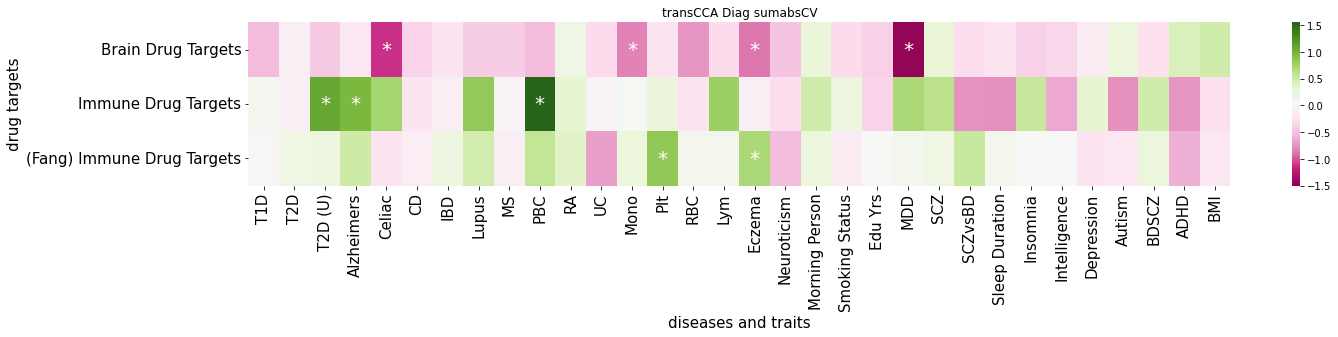

In [118]:
fig = show_L_pwise(drug_L, drug_P, "transCCA Diag sumabsCV", "drug targets", "diseases and traits", estimate_0_targets, estimate_1_targets)
fig.show()

In [ ]:
fig = show_L(drug_L_pcorrected, "transCCA Diag sumabsCV", "drug targets", "diseases and traits", estimate_0_targets, estimate_1_targets)
pp.savefig(fig, bbox_inches='tight')
plt.close(fig)

### marginal feature selection

In [92]:
files = sorted(set([i for i in os.listdir(f"/lila/data/deyk/fabiha/20231221_xuewei_trans/yifei_eqtlgen/results/{name}_marginal") if ".sumstats.features" in i]))

In [93]:
marginal = []
features = []
for f in files:
    if os.stat(f"/lila/data/deyk/fabiha/20231221_xuewei_trans/yifei_eqtlgen/results/{name}_marginal/{f}").st_size > 0:
        temp = pd.read_csv(f"/lila/data/deyk/fabiha/20231221_xuewei_trans/yifei_eqtlgen/results/{name}_marginal/{f}", sep=" ", header=None)
        temp = temp[temp[3]<0.05]
        features += temp[temp[3]<0.05][0].to_list()
        #marginal.append([".".join(f.split(".")[:-2]), len(temp)/2062])
        marginal.append([".".join(f.split(".")[:-2]), len(temp)])

In [94]:
len(set(features))

10

In [95]:
features = sorted(features)

In [96]:
len([i for i in features if "_binary" in i])

0

In [97]:
marginal = pd.DataFrame(marginal)
marginal.columns = ["diseases and traits", "number of features selected"]

In [98]:
marginal = marginal.sort_values("number of features selected", ascending=False)

In [99]:
marginal = marginal.set_index("diseases and traits")

In [100]:
marginal

,number of features selected
diseases and traits,
UKB_460K.blood_MEAN_PLATELET_VOL,7
UKB_460K.biochemistry_Albumin,6
UKB_460K.blood_MONOCYTE_COUNT,6
UKB_460K.biochemistry_ApolipoproteinA,6
UKB_460K.biochemistry_HDLcholesterol,6
...,...
PASS_Neuroticism,1
PASS_LDL,1
PASS_Height1,1


In [101]:
marginal.sum()

number of features selected    351
dtype: int64

In [102]:
marginal[marginal["number of features selected"]>0]

,number of features selected
diseases and traits,
UKB_460K.blood_MEAN_PLATELET_VOL,7
UKB_460K.biochemistry_Albumin,6
UKB_460K.blood_MONOCYTE_COUNT,6
UKB_460K.biochemistry_ApolipoproteinA,6
UKB_460K.biochemistry_HDLcholesterol,6
...,...
PASS_Neuroticism,1
PASS_LDL,1
PASS_Height1,1


In [103]:
temp_marginal = ['UKB_460K.blood_RED_COUNT',
 'UKB_460K.blood_PLATELET_COUNT',
 'UKB_460K.blood_WHITE_COUNT',
 'UKB_460K.biochemistry_HDLcholesterol',
 'UKB_460K.biochemistry_LDLdirect',
 'UKB_460K.disease_CARDIOVASCULAR',
 'PASS_Alzheimers_Jansen2019',
 'UKB_460K.mental_NEUROTICISM',
 'PASS_Rheumatoid_Arthritis',
 'PASS_Schizophrenia'
]

In [81]:
temp = marginal.copy(deep=True)

In [82]:
temp = temp.loc[temp_marginal]

In [84]:
temp.index = [traits_name[i] for i in list(temp.index)]

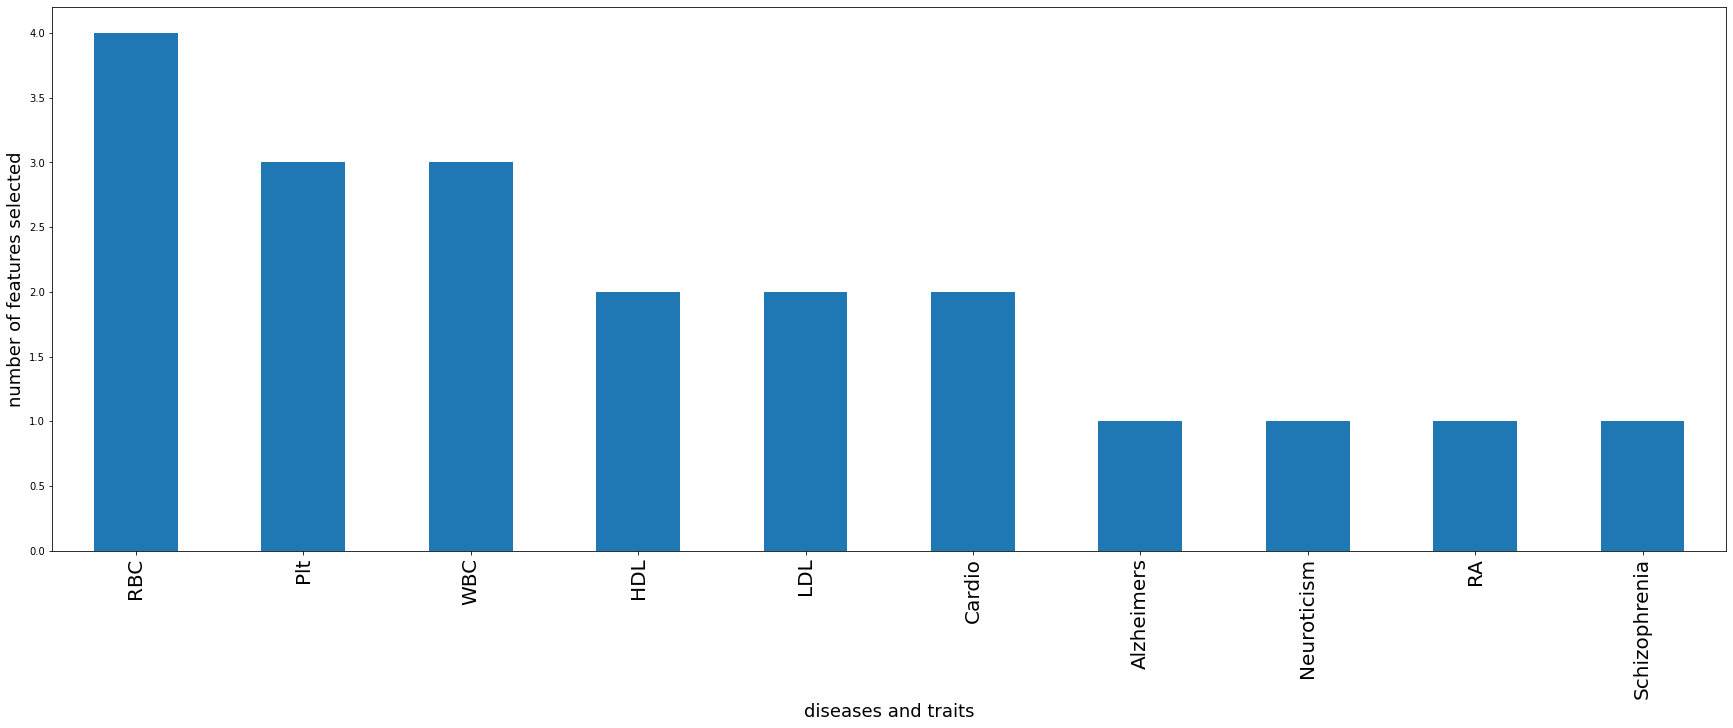

In [91]:
plt.rcParams["figure.figsize"] = (30,10)
temp[temp["number of features selected"]>0].plot.bar(legend=None)
plt.xlabel("diseases and traits", fontsize=18)
plt.xticks(fontsize=20)
plt.ylabel("number of features selected", fontsize=18)
plt.show()

In [ ]:
pp.close()